Loading and preprocessing data...
Computing MLE estimates...
mean:  {0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
     

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


LDA - Train: 1.000, Test: 0.830
QDA - Train: 1.000, Test: 0.500

PCA transformed data (95% variance):
LDA - Train: 0.983, Test: 0.953
QDA - Train: 1.000, Test: 0.950

FDA transformed data:
LDA - Train: 0.897, Test: 0.883
QDA - Train: 0.930, Test: 0.917


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


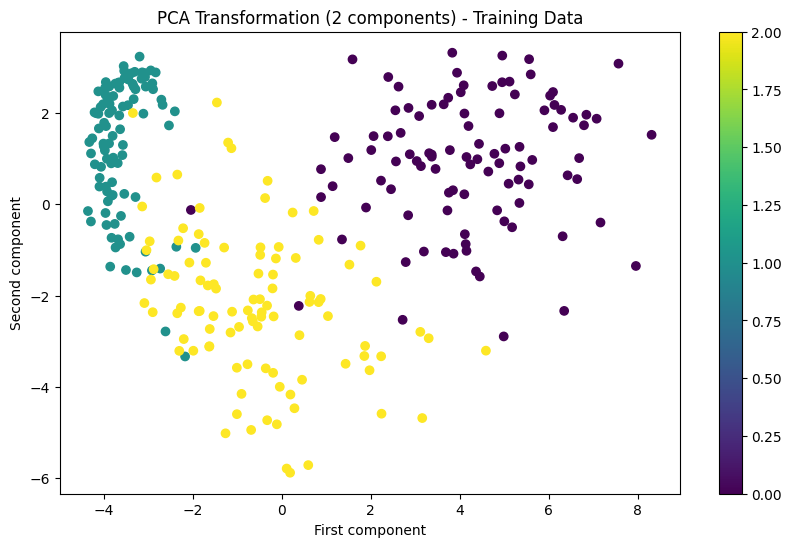

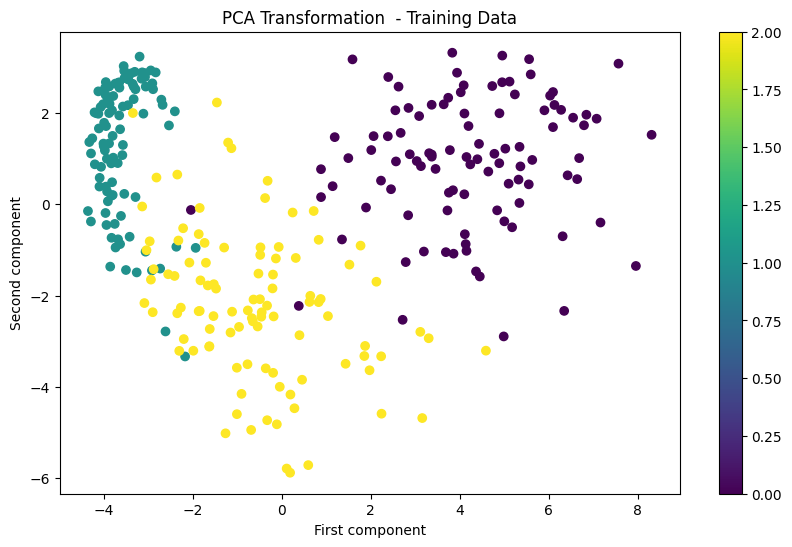

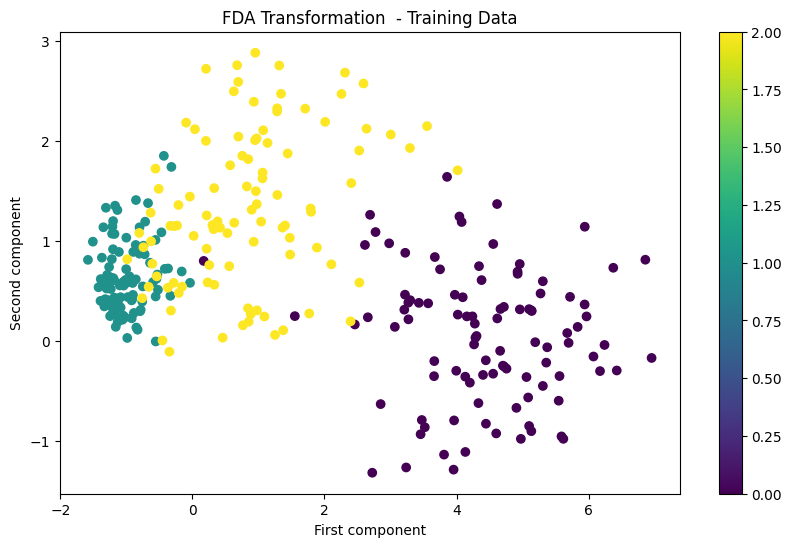

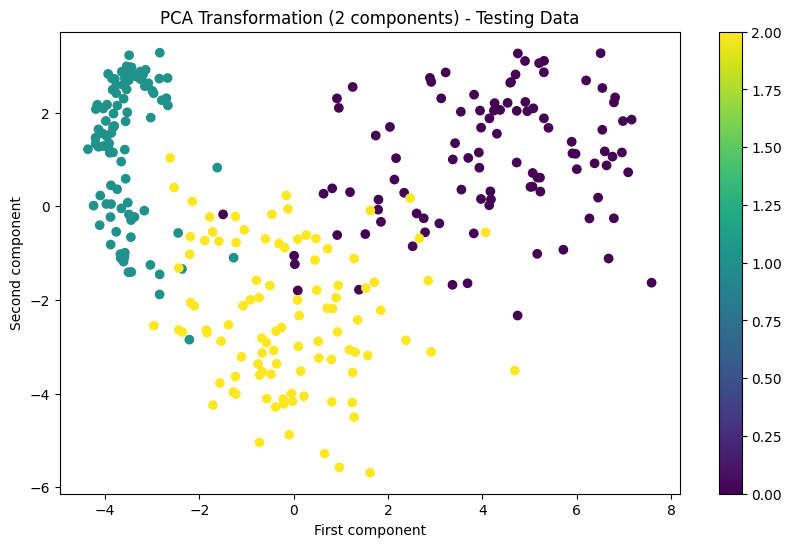

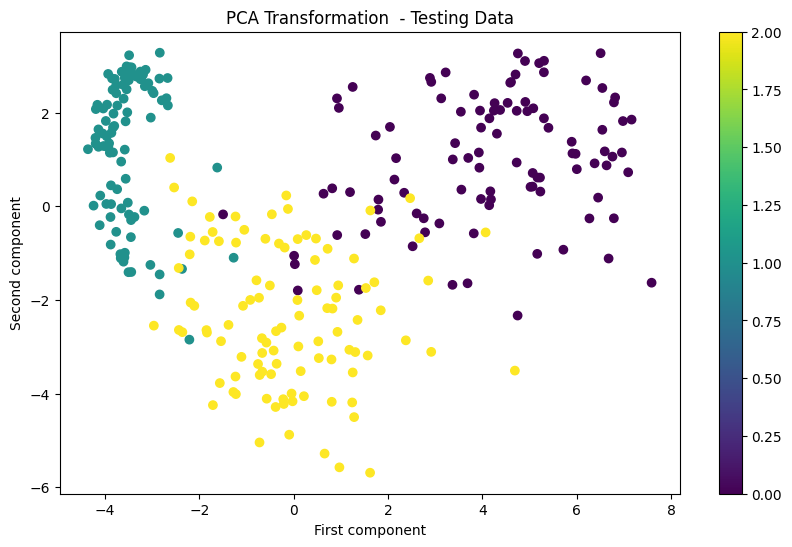

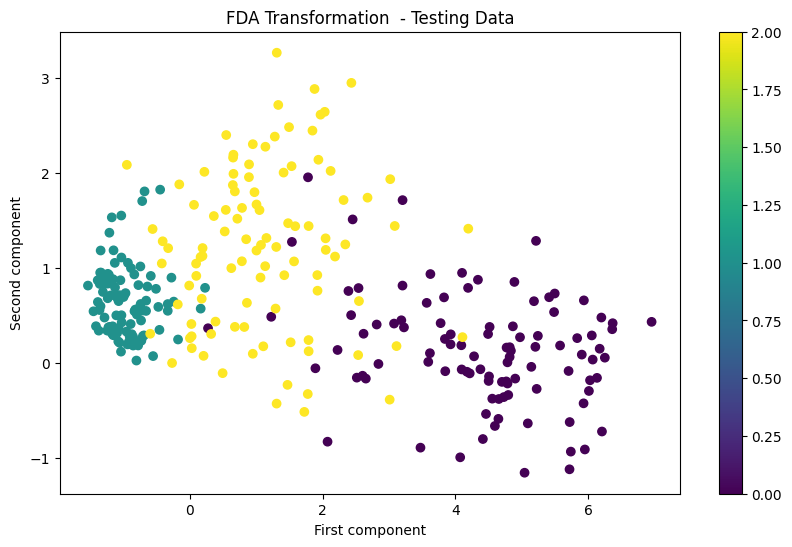

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import seaborn as sns

def load_and_preprocess_data(n_samples_per_class=100):
    """Load and preprocess MNIST data for digits 0, 1, and 2."""
    # Load MNIST dataset
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert labels to integers
    y = y.astype(int)

    # Filter only digits 0, 1, and 2
    mask = np.isin(y, [0, 1, 2])
    X = X[mask]
    y = y[mask]

    # Normalize pixel values to [0, 1]
    X = X / 255.0

    # Split into train and test sets
    train_indices = []
    test_indices = []

    for digit in [0, 1, 2]:
        digit_indices = np.where(y == digit)[0]
        np.random.shuffle(digit_indices)
        train_indices.extend(digit_indices[:n_samples_per_class])
        test_indices.extend(digit_indices[-n_samples_per_class:])

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, y_train, X_test, y_test

def compute_mle_estimates(X, y):
    """Compute Maximum Likelihood Estimates for each class."""
    classes = np.unique(y)
    means = {}
    covs = {}

    for c in classes:
        X_c = X[y == c]
        means[c] = np.mean(X_c, axis=0)
        covs[c] = np.cov(X_c.T)

    return means, covs

def apply_pca(X_train, X_test, variance_threshold=0.95):
    """Apply PCA and reduce dimensionality."""
    # Center the data
    scaler = StandardScaler(with_std=False)
    X_train_centered = scaler.fit_transform(X_train)
    X_test_centered = scaler.transform(X_test)

    # Compute covariance matrix
    cov_matrix = np.cov(X_train_centered.T)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Calculate cumulative variance ratio
    total_var = np.sum(eigenvalues)
    var_ratio = np.cumsum(eigenvalues) / total_var

    # Select number of components for desired variance
    n_components = np.argmax(var_ratio >= variance_threshold) + 1

    # Project data onto principal components
    Up = eigenvectors[:, :n_components]
    X_train_pca = np.dot(X_train_centered, Up)
    X_test_pca = np.dot(X_test_centered, Up)

    return X_train_pca, X_test_pca, Up

def compute_scatter_matrices(X, y):
    """Compute between-class and within-class scatter matrices."""
    classes = np.unique(y)
    n_features = X.shape[1]

    # Global mean
    global_mean = np.mean(X, axis=0)

    # Initialize scatter matrices
    Sb = np.zeros((n_features, n_features))
    Sw = np.zeros((n_features, n_features))

    # Compute scatter matrices
    for c in classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]

        # Between-class scatter
        mean_diff = (mean_c - global_mean).reshape(-1, 1)
        Sb += n_c * np.dot(mean_diff, mean_diff.T)

        # Within-class scatter
        for x in X_c:
            x_diff = (x - mean_c).reshape(-1, 1)
            Sw += np.dot(x_diff, x_diff.T)
    print("Sb\n",Sb)
    print( "Sw\n",Sw)
    print( "ST\n",Sw+Sb)
    print()

    return Sb, Sw
def apply_fda(X_train, X_test, y_train, n_components=2):
    """Apply Fisher Discriminant Analysis using pseudoinverse."""
    # Compute scatter matrices
    Sb, Sw = compute_scatter_matrices(X_train, y_train)

    # Compute pseudoinverse of Sw
    Sw_pinv = np.linalg.pinv(Sw)

    # Compute Sw_pinv * Sb
    M = np.dot(Sw_pinv, Sb)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(M)

    # Sort eigenvectors in descending order of eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    # Select top components
    W = eigenvectors[:, :n_components]
    print("W: ",W)
    print()
    # Project data
    X_train_fda = np.dot(X_train, W)
    X_test_fda = np.dot(X_test, W)

    return X_train_fda, X_test_fda, W

def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    """Train and evaluate a classifier."""
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    return train_acc, test_acc

def plot_2d_data(X, y, title):
    """Plot 2D transformed data."""
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.show()

# Main execution
def main():
    # Set random seed for reproducibility
    np.random.seed(42)

    # 1. Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # 2. Compute MLE estimates
    print("Computing MLE estimates...")
    means, covs = compute_mle_estimates(X_train, y_train)
    print("mean: ",means)
    print("cov: ",covs)
    print()

    # 3. Apply PCA with 95% variance
    print("Applying PCA...")
    X_train_pca, X_test_pca, _ = apply_pca(X_train, X_test, variance_threshold=0.95)

    # Apply PCA with 2 components for visualization
    X_train_pca_2d, X_test_pca_2d, _ = apply_pca(X_train, X_test, variance_threshold=0.5)

    #Apply PCA with 90% variance
    print("Applying PCA...")
    X_train_pca, X_test_pca, _ = apply_pca(X_train, X_test, variance_threshold=0.90)

    # 4. Apply FDA
    print("Applying FDA...")
    X_train_fda, X_test_fda, _ = apply_fda(X_train, X_test, y_train)


    # 5. Evaluate classifiers
    print("\nEvaluating classifiers...")

    # Initialize classifiers
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()

    # Original data
    print("\nOriginal data:")
    lda_train_acc, lda_test_acc = evaluate_classifier(lda, X_train, X_test, y_train, y_test)
    qda_train_acc, qda_test_acc = evaluate_classifier(qda, X_train, X_test, y_train, y_test)
    print(f"LDA - Train: {lda_train_acc:.3f}, Test: {lda_test_acc:.3f}")
    print(f"QDA - Train: {qda_train_acc:.3f}, Test: {qda_test_acc:.3f}")

    # PCA transformed data (95% variance)
    print("\nPCA transformed data (95% variance):")
    lda_train_acc_pca, lda_test_acc_pca = evaluate_classifier(lda, X_train_pca, X_test_pca, y_train, y_test)
    qda_train_acc_pca, qda_test_acc_pca = evaluate_classifier(qda, X_train_pca, X_test_pca, y_train, y_test)
    print(f"LDA - Train: {lda_train_acc_pca:.3f}, Test: {lda_test_acc_pca:.3f}")
    print(f"QDA - Train: {qda_train_acc_pca:.3f}, Test: {qda_test_acc_pca:.3f}")

    # FDA transformed data
    print("\nFDA transformed data:")
    lda_train_acc_fda, lda_test_acc_fda = evaluate_classifier(lda, X_train_fda, X_test_fda, y_train, y_test)
    qda_train_acc_fda, qda_test_acc_fda = evaluate_classifier(qda, X_train_fda, X_test_fda, y_train, y_test)
    print(f"LDA - Train: {lda_train_acc_fda:.3f}, Test: {lda_test_acc_fda:.3f}")
    print(f"QDA - Train: {qda_train_acc_fda:.3f}, Test: {qda_test_acc_fda:.3f}")

    # Visualize 2D transformations
    plot_2d_data(X_train_pca_2d, y_train, 'PCA Transformation (2 components) - Training Data')
    plot_2d_data(X_train_pca, y_train, 'PCA Transformation  - Training Data')
    plot_2d_data(X_train_fda, y_train, 'FDA Transformation  - Training Data')


    plot_2d_data(X_test_pca_2d, y_test, 'PCA Transformation (2 components) - Testing Data')
    plot_2d_data(X_test_pca, y_test, 'PCA Transformation  - Testing Data')
    plot_2d_data(X_test_fda, y_test, 'FDA Transformation  - Testing Data')
if __name__ == "__main__":
    main()